# Sequentially Comparing Forecasters on Synthetic Data

Here, we compare our Hoeffding-style and Empirical-Bernstein CSs, as well as an asymptotic CS ([Waudby-Smith et al., 2021](https://arxiv.org/abs/2103.06476)) and a fixed-time CI ([Lai et al., 2011](https://doi.org/10.1214/11-AOS902), on a non-IID synthetic data.

See also: Section 5.1 in our paper.

YJ Choe [yjchoe@cmu.edu]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import comparecast as cc

## Hyperparameter Settings

In [2]:
# which scoring rule to use (lo, hi: bounds on score differentials)
scoring_rule = "brier"
lo, hi = -1, 1

# significance level
alpha = 0.05

# whether to use the log scale on x-axis (time)
use_logx = True

## Forecasts on Synthetic Data

The synthetic data as well as the forecasts are generated from the command line via:
```shell
python forecast.py -d default -n 10000 -f all -o forecasts/default.csv -p plots/default
```

In [3]:
data_name = "default"
data_file = f"forecasts/{data_name}.csv"
plots_dir = f"plots/{data_name}"

data = cc.data_utils.synthetic.get_data(data_file)
data

,time,data,true_probs,laplace,k29_poly3,k29_rbf0.01,always_0.5,always_0,always_1
0,1,1,0.676405,0.500000,0.500000,0.500000,0.5,0.0,1.0
1,2,1,0.540016,1.000000,0.000000,0.000000,0.5,0.0,1.0
2,3,1,0.597874,1.000000,1.000000,1.000000,0.5,0.0,1.0
3,4,0,0.724089,1.000000,1.000000,1.000000,0.5,0.0,1.0
4,5,1,0.686756,0.800000,1.000000,1.000000,0.5,0.0,1.0
...,...,...,...,...,...,...,...,...,...
9995,9996,0,0.019072,0.493497,0.201172,0.204102,0.5,0.0,1.0
9996,9997,0,0.204236,0.493448,0.210938,0.204102,0.5,0.0,1.0
9997,9998,0,0.251687,0.493399,0.208984,0.204102,0.5,0.0,1.0
9998,9999,0,0.196708,0.493349,0.206055,0.204102,0.5,0.0,1.0


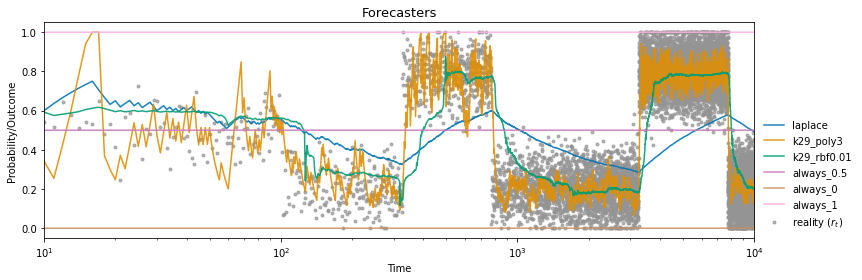

In [4]:
cc.plot_forecasts(data, ["all"], plots_dir, use_logx=use_logx)

## CS for $\Delta_t(\hat{p}_\text{k29-poly3}, \hat{p}_\text{laplace})$

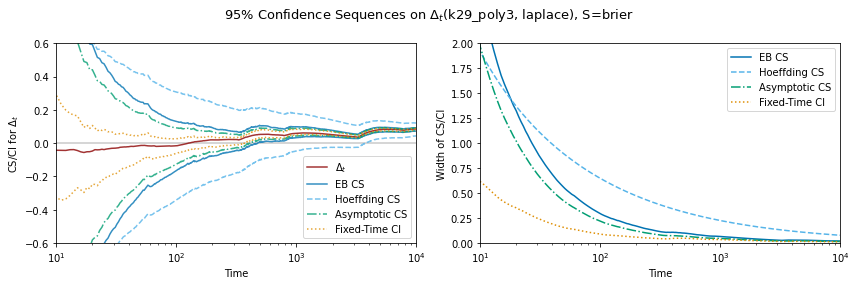

In [5]:
name_p = "k29_poly3"
name_q = "laplace"
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    lo=lo,
    hi=hi,
    compare_baselines=("h", "acs", "ci"),
    use_logx=use_logx,
)

## Examing Interesting Scenarios

We're interested in three particular cases:
- $p$ is strictly better than $q$ always (e.g., true_probs vs random);
- $p$ and $q$ are alternatingly good;
- $p$ is "usually" but not always better than $q$ (say, better 80% of the time and worse 20% of the time).

### Case 1: $p$ is strictly better than $q$

We expect $\Delta_t(p; q)$ to be positive, as $S(p, y)$ is expected to be smaller than $S(q, y)$.

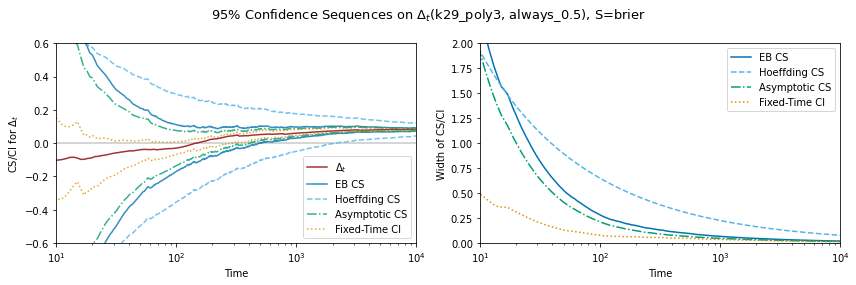

In [6]:
name_p = "k29_poly3"
name_q = "always_0.5"
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    lo=lo,
    hi=hi,
    compare_baselines=("h", "acs", "ci"),
    use_logx=use_logx,
)

### Case 2: $p$ and $q$ are alternatingly good

We expect $\Delta_t$ to tend to zero, as no forecaster dominates the other.

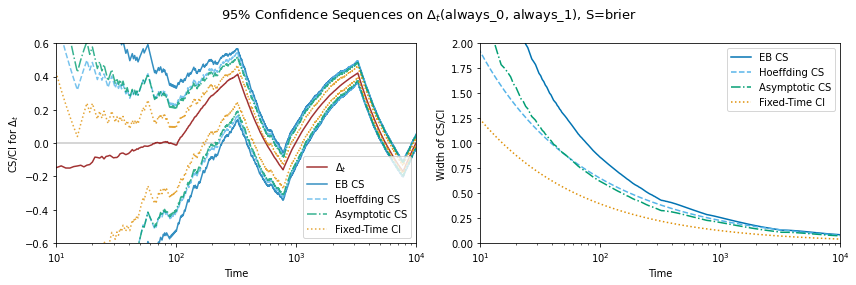

In [7]:
name_p = "always_0"
name_q = "always_1"
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    lo=lo,
    hi=hi,
    compare_baselines=("h", "acs", "ci"),
    use_logx=use_logx,
)

### Case 3: $p$ is usually better than $q$, but not always

We expect $\Delta_t$ to be positive, but it should be closer to zero the less often $p$ is actually better than $q$.

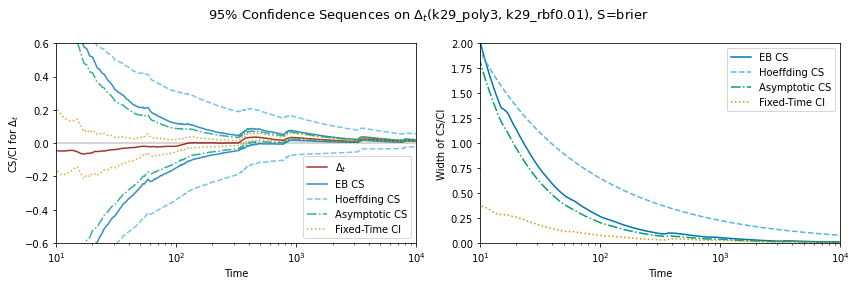

In [8]:
name_p = "k29_poly3"
name_q = "k29_rbf0.01"
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    lo=lo,
    hi=hi,
    compare_baselines=("h", "acs", "ci"),
    use_logx=use_logx,
)

## Comparing Many Forecasters

We now compare all pairs between four forecasters for this dataset.

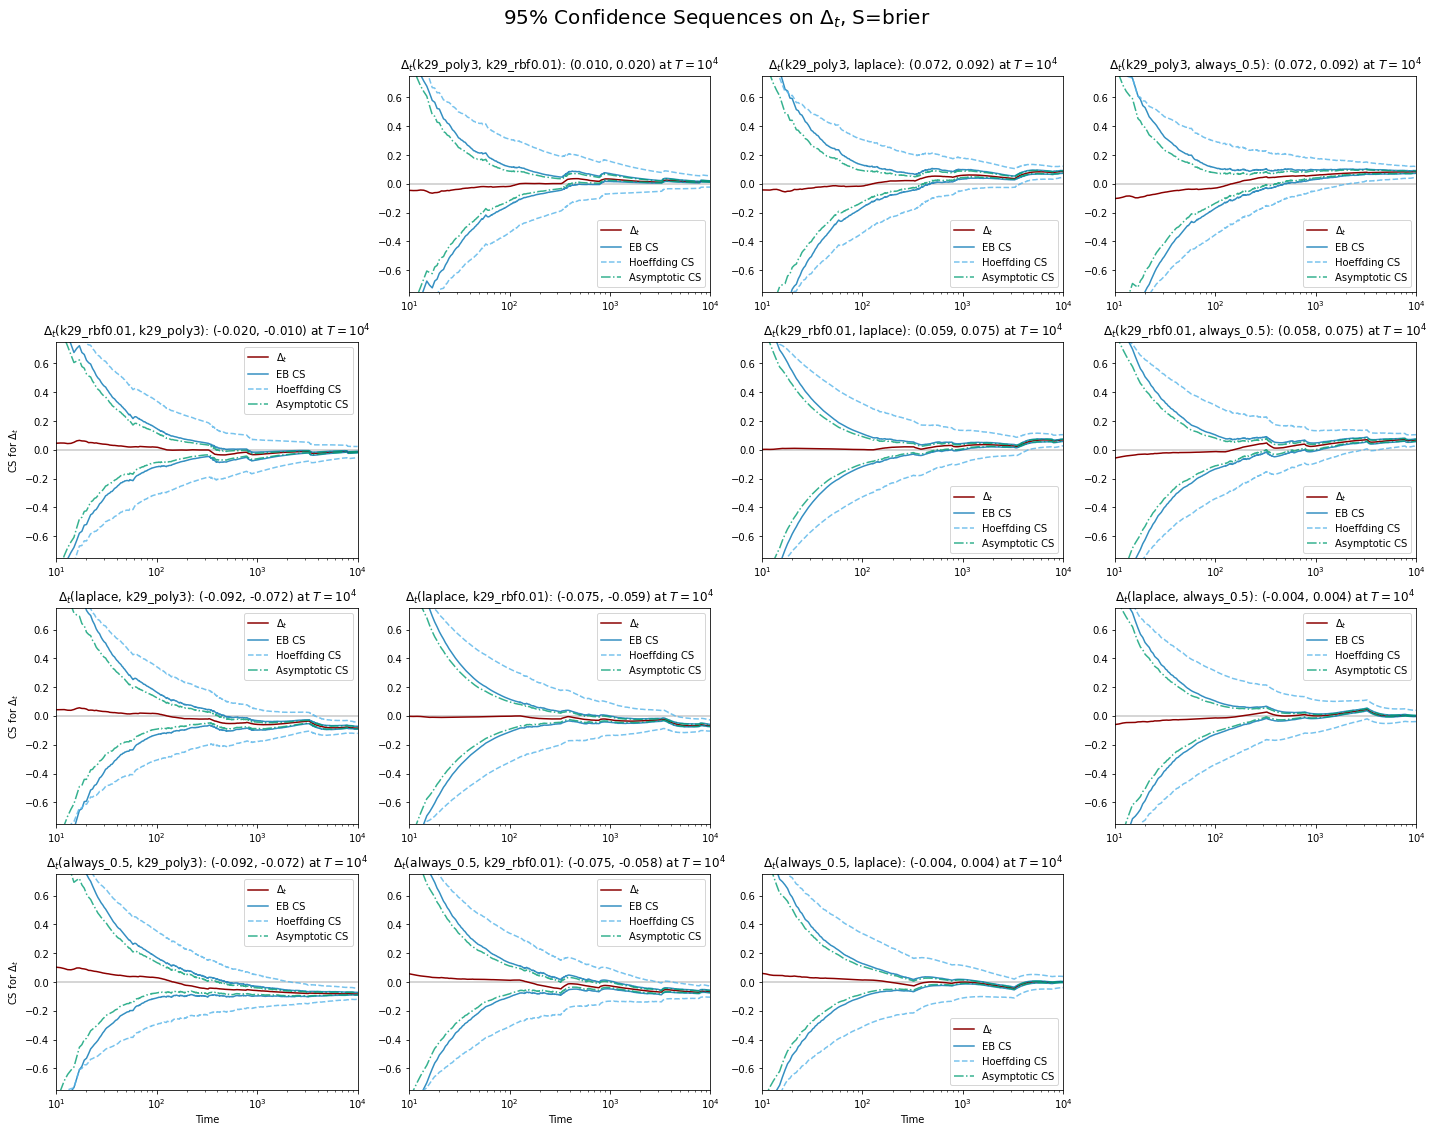

In [9]:
forecasters = ["k29_poly3", "k29_rbf0.01", "laplace", "always_0.5"]
axes = cc.plot_pairwise_comparisons(
    data,
    forecasters, 
    scoring_rule=scoring_rule,
    plots_dir=plots_dir, 
    alpha=alpha,
    lo=lo,
    hi=hi,
    compare_baselines=("h", "acs"),
    use_logx=use_logx,
)